In [6]:
Copyright (c) [2018] [Prabhash Kumar Jha and Isheeta Jha] 


using PyPlot
using JLD


# Load the Bayer image from the provided .jld file
function loadbayer()
  data=JLD.load("bayerdata.jld","bayerimg")
  return data::Array{Float64,2}
end


# Separate the Bayer image into three images (one for each color channel), filling up all
# unknown values with 0
function separatebayer(data::Array{Float64,2})

Nr=size(data,1)
Nc=size(data,2)
r=zeros(Nr,Nc)
g=zeros(Nr,Nc)
b=zeros(Nr,Nc)
for i=1:Nr
    for j=1:Nc
        if((i & 0x1) == 0x1)  #odd row->red pixel row
            if((j & 0x1) == 0x1)
                g[i,j]=data[i,j] #red pixel row odd column element is green
            else
                r[i,j]=data[i,j]
            end
        else #even row->blue pixel row
            if((j & 0x1) == 0x1)
                b[i,j]=data[i,j]#blue pixel row odd column element is blue
            else
                g[i,j]=data[i,j]
           end
        end
    end
end
  return r::Array{Float64,2}, g::Array{Float64,2}, b::Array{Float64,2}
end


# Combine three color channels into a single image
function makeimage(r::Array{Float64,2}, g::Array{Float64,2}, b::Array{Float64,2})
Nr=size(r,1) #no. of rows
Nc=size(r,2) #no. of columns
image=zeros(Nr,Nc,3)#create 3-d array with rgb components
image[:,:,1] = r[:,:]
image[:,:,2] = g[:,:]
image[:,:,3] = b[:,:]
image=image/255 #normalize value to range 0-1
return image::Array{Float64,3}
end


# Interpolate missing color values using bilinear interpolation
function debayer(r::Array{Float64,2}, g::Array{Float64,2}, b::Array{Float64,2})
Nr=size(r,1) #no. of rows
Nc=size(r,2)#no. of columns
weights_red = [0.25 0.5 0.25; 0.5 1 0.5; 0.25 0.5 0.25]
weights_blue = [0.25 0.5 0.25; 0.5 1 0.5; 0.25 0.5 0.25]
weights_green = [0 0.25 0; 0.25 1 0.25; 0 0.25 0]
image=zeros(Nr,Nc,3)
for i=1:Nr
    for j=1:Nc
        kernel_r=zeros(3,3)
        kernel_g=zeros(3,3)
        kernel_b=zeros(3,3)
        if(i>1)
            if(j>1) 
                kernel_r[1,1]=weights_red[1,1]*r[i-1,j-1]
                kernel_g[1,1]=weights_green[1,1]*g[i-1,j-1]
                kernel_b[1,1]=weights_blue[1,1]*b[i-1,j-1]
            end
            kernel_r[1,2]=weights_red[1,2]*r[i-1,j]
            kernel_g[1,2]=weights_green[1,2]*g[i-1,j]
            kernel_b[1,2]=weights_blue[1,2]*b[i-1,j]
            if(j<Nc)
                kernel_r[1,3]=weights_red[1,3]*r[i-1,j+1]
                kernel_g[1,3]=weights_green[1,3]*g[i-1,j+1]
                kernel_b[1,3]=weights_blue[1,3]*b[i-1,j+1]    
            end
        end
        if(j>1) 
            kernel_r[2,1]=weights_red[2,1]*r[i,j-1]
            kernel_g[2,1]=weights_green[2,1]*g[i,j-1]
            kernel_b[2,1]=weights_blue[2,1]*b[i,j-1]
        end
        kernel_r[2,2]=weights_red[2,2]*r[i,j]
        kernel_g[2,2]=weights_green[2,2]*g[i,j]
        kernel_b[2,2]=weights_blue[2,2]*b[i,j]
        if(j<Nc) 
            kernel_r[2,3]=weights_red[2,3]*r[i,j+1]
            kernel_g[2,3]=weights_green[2,3]*g[i,j+1]
            kernel_b[2,3]=weights_blue[2,3]*b[i,j+1]
        end
        if(i<Nr-1)
            if(j>1) 
                kernel_r[3,1]=weights_red[3,1]*r[i+1,j-1]
                kernel_g[3,1]=weights_green[3,1]*g[i+1,j-1]
                kernel_b[3,1]=weights_blue[3,1]*b[i+1,j-1]
            end
            kernel_r[3,2]=weights_red[3,2]*r[i+1,j]
            kernel_g[3,2]=weights_green[3,2]*g[i+1,j]
            kernel_b[3,2]=weights_blue[3,2]*b[i+1,j]
            if(j<Nc)
                kernel_r[3,3]=weights_red[3,3]*r[i+1,j+1]
                kernel_g[3,3]=weights_green[3,3]*g[i+1,j+1]
                kernel_b[3,3]=weights_blue[3,3]*b[i+1,j+1]
            end
        end
image[i,j,1] = sum(kernel_r)
image[i,j,2] = sum(kernel_g)
image[i,j,3] = sum(kernel_b)
    end
end
image=image/255 #normalize value to range 0-1
  return image::Array{Float64,3}
end


# display two images in a single figure window
function displayimages(img1::Array{Float64,3}, img2::Array{Float64,3})
figure()
subplot(1,2,1)
PyPlot.imshow(img1)
PyPlot.title("Raw Bayer image")
subplot(1,2,2)
PyPlot.imshow(img2)
PyPlot.title("Interpolated image")
 
  return nothing
end





displayimages (generic function with 1 method)

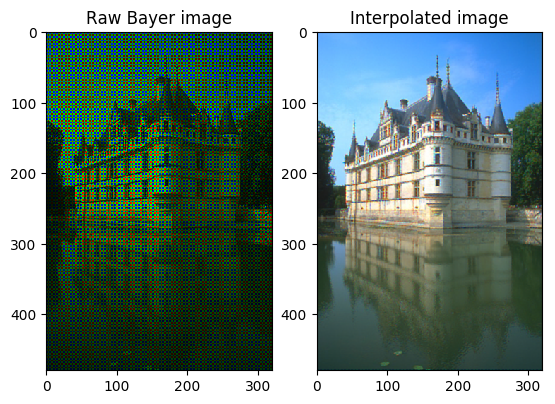

In [7]:
 # load raw data
  data = loadbayer()

  # separate data
  r,g,b = separatebayer(data)

  # merge raw Bayer
  img1 = makeimage(r,g,b)

  # interpolate Bayer
  img2 = debayer(r,g,b)

  # display images
  displayimages(img1, img2)

